In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import scipy.signal
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.interpolate import interp1d
from pydub import AudioSegment
import pywt
import optimalK
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import davies_bouldin_score
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.manifold import Isomap
from sklearn.metrics import silhouette_score
from collections import Counter
import itertools
import os
import pickle
import random
from collections import defaultdict

In [2]:
folder_path = '../audios/lab_audios/first_batch/'
with open(f'{folder_path}all_segments.pkl', 'rb') as file:
    all_segments = pickle.load(file)

In [3]:
def band_stop_filter(y, sr, highcut, order=4):
    nyquist = 0.5 * sr
    normal_cutoff = highcut / nyquist
    b, a = scipy.signal.butter(order, normal_cutoff, btype='high', analog=False)
    y_filtered = scipy.signal.filtfilt(b, a, y)
    return y_filtered

def process_individual_snippets_with_fft(all_segments, file_names, sr=None):
    processed_segments_fft = []
    
    file_idx = 0
    while file_idx < len(file_names):
        file_name = file_names[file_idx]
        print(f"Loading file: {file_name}")
        
        try:
            y, original_sr = librosa.load(file_name, sr=sr)
            y = band_stop_filter(y, original_sr, highcut=900)
        except FileNotFoundError:
            print(f"File {file_name} not found. Skipping.")
            file_idx += 1
            continue

        file_segments = [segment for segment in all_segments if segment['file_name'] == file_name]

        for idx, segment in enumerate(file_segments):
            start_time = segment['start_time']
            end_time = segment['end_time']
            
            print(f"Processing snippet {idx + 1}/{len(file_segments)}: {start_time:.2f}s to {end_time:.2f}s")

            start_idx = int(start_time * original_sr)
            end_idx = int(end_time * original_sr)
            
            snippet = y[start_idx:end_idx]
            
            fft_result = np.fft.fft(snippet)
            fft_magnitude = np.abs(fft_result)
            fft_frequencies = np.fft.fftfreq(len(snippet), d=1/original_sr)  # Get frequencies
            
            processed_segments_fft.append({
                'file_name': file_name,
                'start_time': start_time,
                'end_time': end_time,
                'fft_magnitude': fft_magnitude,
                'fft_frequencies': fft_frequencies
            })

        file_idx += 1

    return processed_segments_fft


In [4]:
folder_path = '../audios/lab_audios/first_batch/'
file_names = [f'{folder_path}recording_20240927_204919-{i:02d}.wav' for i in range(1, 17)]
# processed_segments_fft = process_individual_snippets_with_fft(all_segments, file_names)

# # Save the results if needed
# with open(f'{folder_path}processed_segments_fft.pkl', 'wb') as file:
#     pickle.dump(processed_segments_fft, file)

# print("FFT processing complete. Results saved.")


with open(f'{folder_path}processed_segments_fft.pkl', 'rb') as file:
    processed_segments_fft = pickle.load(file)

In [5]:
for segment in processed_segments_fft:
    # Get the fft_frequencies and fft_magnitude fields
    fft_frequencies = segment['fft_frequencies']
    fft_magnitude = segment['fft_magnitude']
    
    # Filter for non-negative frequencies
    non_negative_indices = fft_frequencies >= 0
    segment['fft_frequencies'] = fft_frequencies[non_negative_indices]
    segment['fft_magnitude'] = fft_magnitude[non_negative_indices]

print("Negative frequencies have been removed from all segments.")

Negative frequencies have been removed from all segments.


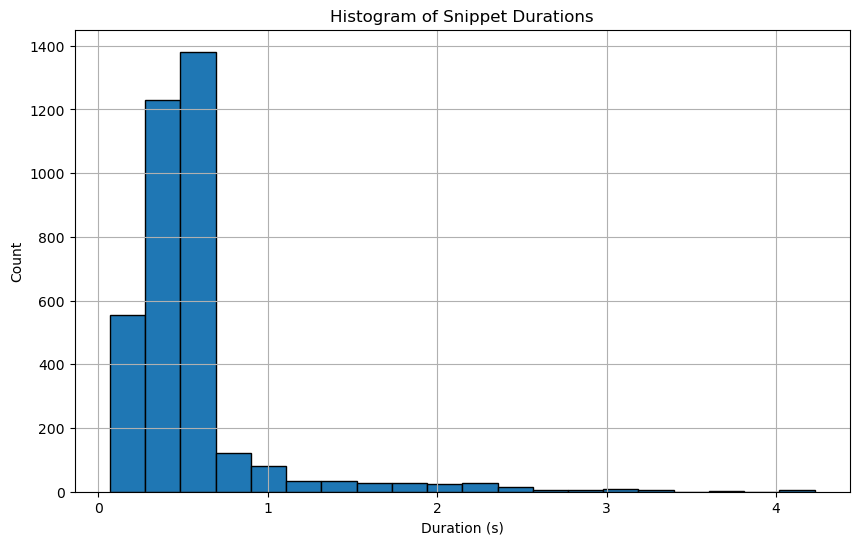

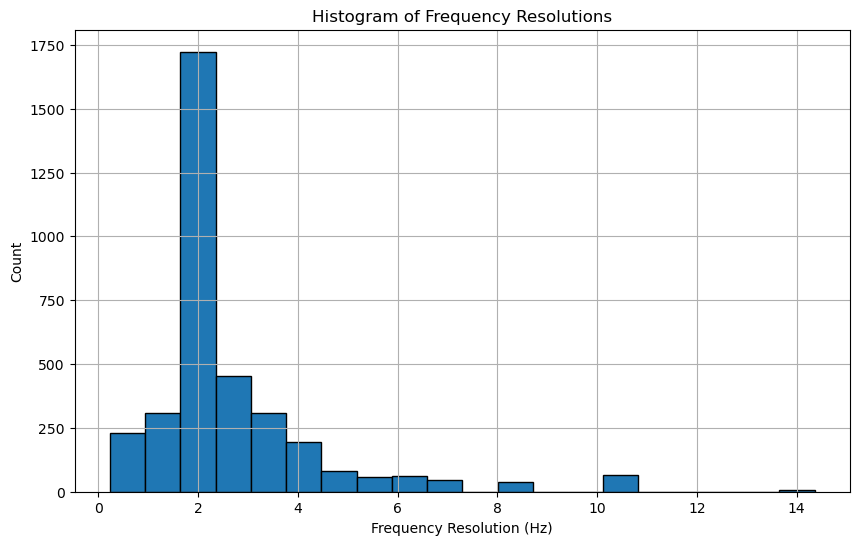

In [6]:
durations = [segment['end_time'] - segment['start_time'] for segment in processed_segments_fft]
plt.figure(figsize=(10, 6))
plt.hist(durations, bins=20, edgecolor='black')
plt.xlabel('Duration (s)')
plt.ylabel('Count')
plt.title('Histogram of Snippet Durations')
plt.grid(True)
plt.show()

frequency_resolutions = []
for segment in processed_segments_fft:
    fft_frequencies = segment['fft_frequencies']
    positive_frequencies = fft_frequencies[fft_frequencies >= 0]  # Only positive frequencies
    resolution = np.min(np.diff(positive_frequencies))
    frequency_resolutions.append(resolution)

plt.figure(figsize=(10, 6))
plt.hist(frequency_resolutions, bins=20, edgecolor='black')
plt.xlabel('Frequency Resolution (Hz)')
plt.ylabel('Count')
plt.title('Histogram of Frequency Resolutions')
plt.grid(True)
plt.show()

In [7]:
print(processed_segments_fft[0]['fft_magnitude'][0])

0.011074838859822193


In [8]:
def plot_multiple_fft_magnitudes(segments, num_segments_to_plot=10):
    plt.figure(figsize=(15, 10))
    for i, segment in enumerate(segments[:num_segments_to_plot], start=1):
        fft_magnitude = segment['fft_magnitude']
        fft_frequencies = segment['fft_frequencies']
        
        plt.subplot(2, 5, i)
        plt.plot(fft_frequencies, fft_magnitude)
        plt.title(f"Segment {i}")
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.grid()
    
    plt.tight_layout()
    plt.show()


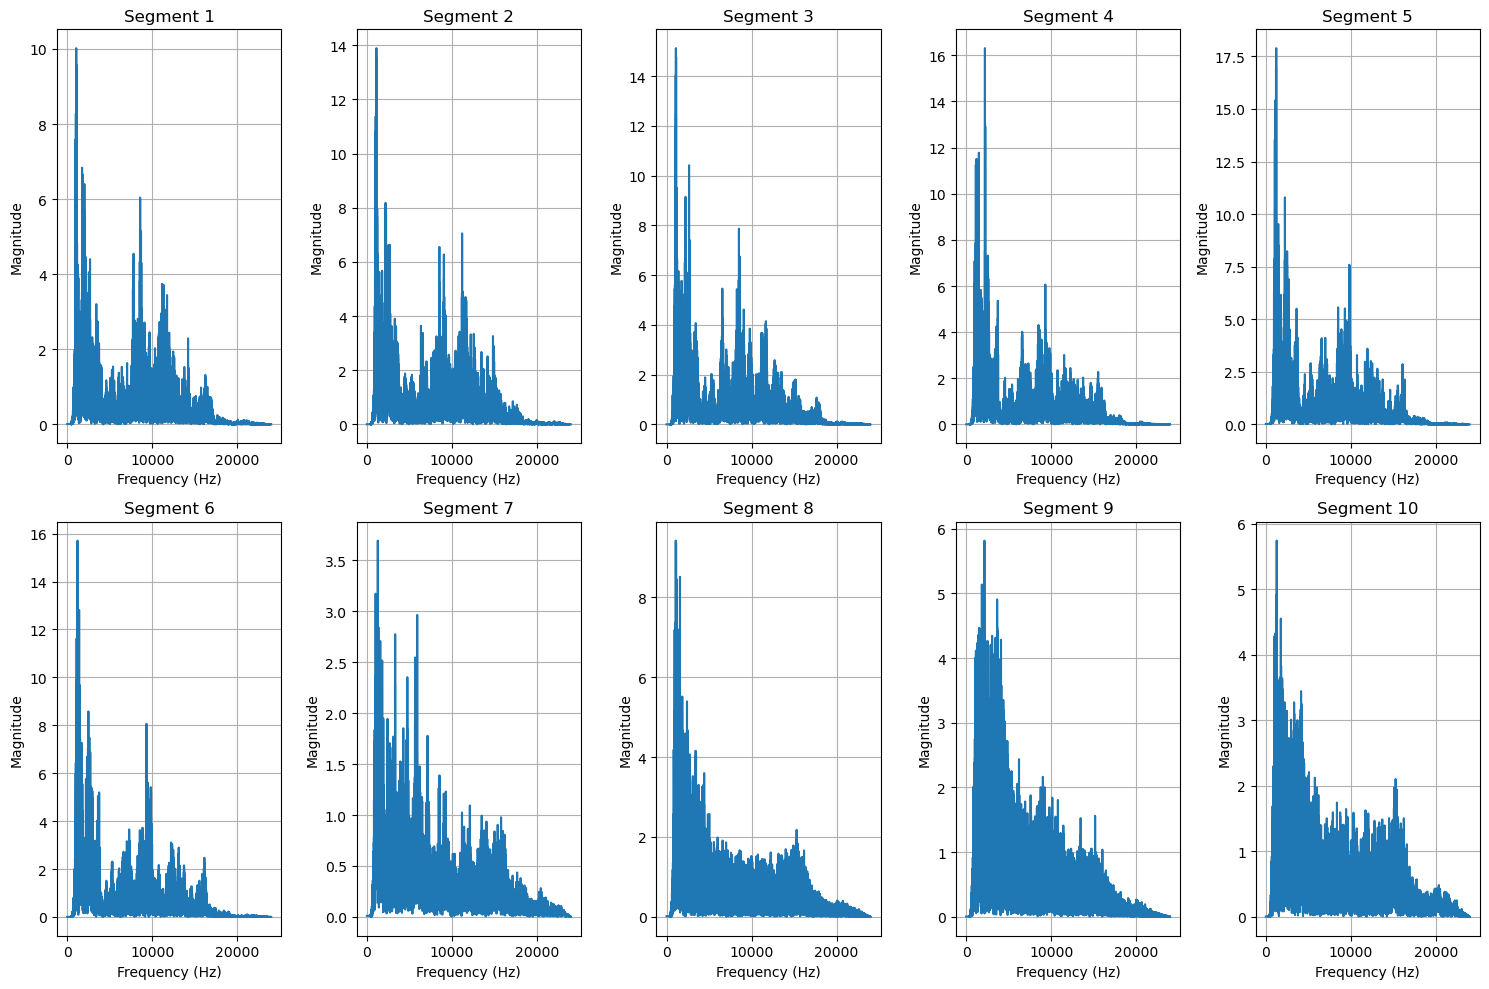

In [9]:
plot_multiple_fft_magnitudes(processed_segments_fft, num_segments_to_plot=10)


In [10]:
def pad_fft_magnitudes(processed_segments_fft):
    max_length = max(len(segment['fft_magnitude']) for segment in processed_segments_fft)

    for segment in processed_segments_fft:
        fft_magnitude = segment['fft_magnitude']
        padded_magnitude = np.pad(fft_magnitude, (0, max_length - len(fft_magnitude)), mode='constant')
        segment['padded_fft_magnitude'] = padded_magnitude

    return processed_segments_fft

In [11]:
processed_segments_fft = pad_fft_magnitudes(processed_segments_fft)

In [12]:
def verify_frequency_resolution(processed_segments_fft):
    frequency_resolutions = []
    for idx, segment in enumerate(processed_segments_fft):
        fft_frequencies = segment['fft_frequencies']
        delta_f = np.diff(fft_frequencies)
        
        if not np.allclose(delta_f, delta_f[0]):
            print(f"Warning: Non-uniform frequency resolution in segment {idx + 1}")
        
        frequency_resolutions.append(delta_f[0])

    if not np.allclose(frequency_resolutions, frequency_resolutions[0]):
        print("Frequency resolutions vary across segments!")
    else:
        print(f"Frequency resolution is consistent: {frequency_resolutions[0]:.2f} Hz")
    
    return frequency_resolutions

In [13]:
frequency_resolutions = verify_frequency_resolution(processed_segments_fft)

Frequency resolutions vary across segments!


In [14]:
finest_delta_f = min([np.min(np.diff(segment['fft_frequencies'])) for segment in processed_segments_fft])

min_freq = min([min(segment['fft_frequencies']) for segment in processed_segments_fft])
max_freq = max([max(segment['fft_frequencies']) for segment in processed_segments_fft])

common_frequencies = np.arange(min_freq, max_freq, finest_delta_f)

In [15]:
def interpolate_fft_magnitudes(processed_segments_fft, common_frequencies):
    for segment in processed_segments_fft:
        segment['common_frequencies'] = common_frequencies
        fft_frequencies = segment['fft_frequencies']
        fft_magnitude = segment['fft_magnitude']
        
        interp_func = interp1d(fft_frequencies, fft_magnitude, kind='cubic', bounds_error=False, fill_value=0)
        
        interpolated_magnitude = interp_func(common_frequencies)
        segment['interpolated_fft_magnitude'] = interpolated_magnitude
    
    return processed_segments_fft

In [16]:
processed_segments_fft = interpolate_fft_magnitudes(processed_segments_fft, common_frequencies)

# Verify the dimensions
for idx, segment in enumerate(processed_segments_fft[:5]):
    print(f"Segment {idx + 1}: Interpolated magnitude shape = {segment['interpolated_fft_magnitude'].shape}")

Segment 1: Interpolated magnitude shape = (101425,)
Segment 2: Interpolated magnitude shape = (101425,)
Segment 3: Interpolated magnitude shape = (101425,)
Segment 4: Interpolated magnitude shape = (101425,)
Segment 5: Interpolated magnitude shape = (101425,)


In [17]:
# examine artifacts
# for i, segment in enumerate(processed_segments_fft[:5]):
#     plt.figure(figsize=(10, 6))
#     plt.plot(segment['fft_frequencies'], segment['fft_magnitude'], label='Original', marker='o')
#     plt.plot(segment['common_frequencies'], segment['interpolated_fft_magnitude'], label='Interpolated', linestyle='--')
#     plt.title(f"Segment {i + 1} - Original vs Interpolated FFT Magnitudes")
#     plt.xlabel("Frequency (Hz)")
#     plt.ylabel("Magnitude")
#     plt.legend()
#     plt.grid()
#     plt.show()

In [18]:
# errors = []
# for segment in processed_segments_fft:
#     interp_func = interp1d(segment['common_frequencies'], segment['interpolated_fft_magnitude'], 
#                            kind='cubic', bounds_error=False, fill_value=0)
#     interpolated_on_original = interp_func(segment['fft_frequencies'])
#     error = np.sqrt(np.mean((segment['fft_magnitude'] - interpolated_on_original) ** 2))
#     errors.append(error)

# print(f"Mean RMSE: {np.mean(errors):.4f}, Max RMSE: {np.max(errors):.4f}")

In [19]:
# for i, segment in enumerate(processed_segments_fft[:5]):
#     plt.figure(figsize=(10, 6))
#     original_frequencies = segment['fft_frequencies']
#     interp_func = interp1d(segment['common_frequencies'], segment['interpolated_fft_magnitude'], 
#                            kind='cubic', bounds_error=False, fill_value=0)
#     interpolated_on_original = interp_func(original_frequencies)
#     differences = np.abs(segment['fft_magnitude'] - interpolated_on_original)

#     plt.plot(original_frequencies, differences, label="Absolute Difference")
#     plt.title(f"Segment {i + 1} - Interpolation Artifacts")
#     plt.xlabel("Frequency (Hz)")
#     plt.ylabel("Magnitude Difference")
#     plt.legend()
#     plt.grid()
#     plt.show()

In [20]:
def spectral_clustering_workflow(processed_segments_fft, n_clusters=5):
    print("Extracting and standardizing FFT magnitudes...")
    magnitudes = np.array([segment['interpolated_fft_magnitude'] for segment in processed_segments_fft])
    scaler = StandardScaler()
    magnitudes_scaled = scaler.fit_transform(magnitudes)

    print(f"Performing spectral clustering with {n_clusters} clusters...")
    spectral_clustering = SpectralClustering(
        n_clusters=n_clusters,
        affinity='nearest_neighbors',
        random_state=42
    )
    labels = spectral_clustering.fit_predict(magnitudes_scaled)

    for i, segment in enumerate(processed_segments_fft):
        segment['cluster'] = labels[i]

    print("Visualizing cluster sizes...")
    unique_labels, counts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(8, 6))
    plt.bar(unique_labels, counts)
    plt.xlabel('Cluster')
    plt.ylabel('Number of Segments')
    plt.title('Cluster Sizes')
    plt.show()

    print("Analyzing and visualizing average magnitudes per cluster...")
    plt.figure(figsize=(10, 6))
    for cluster_id in unique_labels:
        cluster_magnitudes = [segment['padded_fft_magnitude'] for segment in processed_segments_fft if segment['cluster'] == cluster_id]
        avg_magnitude = np.mean(cluster_magnitudes, axis=0)
        plt.plot(avg_magnitude, label=f"Cluster {cluster_id}")

    plt.xlabel('Frequency Bin')
    plt.ylabel('Average Magnitude')
    plt.title('Average FFT Magnitudes for Clusters')
    plt.legend()
    plt.grid()
    plt.show()

    print("Grouping segments by clusters...")
    clusters = defaultdict(list)
    for segment in processed_segments_fft:
        clusters[segment['cluster']].append(segment)

    return clusters

In [21]:
# Run the clustering workflow
# n_clusters = 15
# clusters = spectral_clustering_workflow(processed_segments_fft, n_clusters=n_clusters)

# # Access clusters for further analysis
# for cluster_id, cluster_segments in clusters.items():
#     print(f"Cluster {cluster_id} contains {len(cluster_segments)} segments.")


In [22]:
def plot_cluster_magnitudes(clusters):
    """
    Plot FFT magnitudes for each cluster, including individual magnitudes and average magnitude.

    Args:
        clusters (dict): A dictionary where keys are cluster IDs and values are lists of segments.
    """
    print("Plotting individual magnitudes and average magnitude for each cluster...")
    for cluster_id, cluster_segments in clusters.items():
        plt.figure(figsize=(10, 6))
        for segment in cluster_segments:
            plt.plot(segment['padded_fft_magnitude'], color='gray', alpha=0.3, linewidth=0.5)

        # Calculate and plot the average magnitude
        magnitudes = [segment['padded_fft_magnitude'] for segment in cluster_segments]
        avg_magnitude = np.mean(magnitudes, axis=0)
        plt.plot(avg_magnitude, color='red', linewidth=2, label='Average Magnitude')

        plt.title(f"Cluster {cluster_id}: FFT Magnitudes")
        plt.xlabel('Frequency Bin')
        plt.ylabel('Magnitude')
        plt.legend()
        plt.grid(True)
        plt.show()

In [23]:
# plot_cluster_magnitudes(clusters)

In [24]:
def process_individual_snippets_with_wavelet(all_segments, file_names, wavelet='db4', sr=None, max_level=None):
    processed_segments_dwt = []
    
    file_idx = 0
    while file_idx < len(file_names):
        file_name = file_names[file_idx]
        print(f"Loading file: {file_name}")
        
        try:
            y, original_sr = librosa.load(file_name, sr=sr)
            y = band_stop_filter(y, original_sr, highcut=900)
        except FileNotFoundError:
            print(f"File {file_name} not found. Skipping.")
            file_idx += 1
            continue

        file_segments = [segment for segment in all_segments if segment['file_name'] == file_name]

        for idx, segment in enumerate(file_segments):
            start_time = segment['start_time']
            end_time = segment['end_time']
            
            print(f"Processing snippet {idx + 1}/{len(file_segments)}: {start_time:.2f}s to {end_time:.2f}s")

            start_idx = int(start_time * original_sr)
            end_idx = int(end_time * original_sr)
            
            snippet = y[start_idx:end_idx]
            
            # Perform DWT
            coeffs = pywt.wavedec(snippet, wavelet=wavelet, level=max_level)
            power_levels = [np.square(np.abs(c)) for c in coeffs]  # Calculate power for each level
            
            processed_segments_dwt.append({
                'file_name': file_name,
                'start_time': start_time,
                'end_time': end_time,
                'wavelet_coeffs': coeffs,
                'wavelet_power_levels': power_levels,
                'frequency_bands': pywt.scale2frequency(wavelet, np.arange(1, len(coeffs) + 1)) * original_sr / 2
            })

        file_idx += 1

    return processed_segments_dwt


In [25]:
folder_path = '../audios/lab_audios/first_batch/'
file_names = [f'{folder_path}recording_20240927_204919-{i:02d}.wav' for i in range(1,17)]
# processed_segments_wavelet = process_individual_snippets_with_wavelet(all_segments, file_names, wavelet='db4')

# # Save the results if needed
# with open(f'{folder_path}processed_segments_DWT.pkl', 'wb') as file:
#     pickle.dump(processed_segments_wavelet, file)

# print("Wavelet processing complete. Results saved.")

with open(f'{folder_path}processed_segments_wavelet.pkl', 'rb') as file:
    processed_segments_wavelet = pickle.load(file)

Loading file: ../audios/lab_audios/first_batch/recording_20240927_204919-01.wav
Processing snippet 1/161: 15.19s to 15.74s
Processing snippet 2/161: 16.67s to 17.23s
Processing snippet 3/161: 22.43s to 23.17s
Processing snippet 4/161: 42.05s to 42.66s
Processing snippet 5/161: 43.19s to 43.72s
Processing snippet 6/161: 45.23s to 45.77s
Processing snippet 7/161: 523.19s to 523.54s
Processing snippet 8/161: 524.42s to 525.54s
Processing snippet 9/161: 525.54s to 526.49s
Processing snippet 10/161: 527.84s to 528.63s
Processing snippet 11/161: 528.83s to 529.00s
Processing snippet 12/161: 529.79s to 530.25s
Processing snippet 13/161: 530.25s to 532.13s
Processing snippet 14/161: 572.95s to 573.25s
Processing snippet 15/161: 575.44s to 575.69s
Processing snippet 16/161: 585.56s to 585.82s
Processing snippet 17/161: 595.62s to 596.06s
Processing snippet 18/161: 597.75s to 598.01s
Processing snippet 19/161: 616.30s to 616.56s
Processing snippet 20/161: 618.84s to 619.07s
Processing snippet 21

Processing snippet 1/298: 17.14s to 17.23s
Processing snippet 2/298: 90.56s to 90.65s
Processing snippet 3/298: 389.84s to 389.93s
Processing snippet 4/298: 920.83s to 921.14s
Processing snippet 5/298: 978.93s to 979.30s
Processing snippet 6/298: 1012.11s to 1012.60s
Processing snippet 7/298: 1099.81s to 1100.67s
Processing snippet 8/298: 1103.18s to 1103.92s
Processing snippet 9/298: 1109.12s to 1109.75s
Processing snippet 10/298: 1114.91s to 1115.67s
Processing snippet 11/298: 1118.85s to 1120.29s
Processing snippet 12/298: 1118.85s to 1120.29s
Processing snippet 13/298: 1123.59s to 1125.31s
Processing snippet 14/298: 1123.59s to 1125.31s
Processing snippet 15/298: 1127.26s to 1127.89s
Processing snippet 16/298: 1130.00s to 1130.72s
Processing snippet 17/298: 1154.03s to 1154.84s
Processing snippet 18/298: 1154.94s to 1155.89s
Processing snippet 19/298: 1155.98s to 1156.59s
Processing snippet 20/298: 1156.79s to 1157.63s
Processing snippet 21/298: 1180.55s to 1183.64s
Processing snip

Processing snippet 257/298: 4158.32s to 4158.76s
Processing snippet 258/298: 4162.36s to 4162.83s
Processing snippet 259/298: 4164.15s to 4164.61s
Processing snippet 260/298: 4166.77s to 4167.17s
Processing snippet 261/298: 4170.91s to 4171.35s
Processing snippet 262/298: 4175.02s to 4175.41s
Processing snippet 263/298: 4197.82s to 4199.44s
Processing snippet 264/298: 4197.82s to 4199.44s
Processing snippet 265/298: 4200.14s to 4200.81s
Processing snippet 266/298: 4201.42s to 4201.95s
Processing snippet 267/298: 4202.49s to 4203.00s
Processing snippet 268/298: 4204.02s to 4204.58s
Processing snippet 269/298: 4205.51s to 4206.02s
Processing snippet 270/298: 4207.32s to 4207.83s
Processing snippet 271/298: 4208.78s to 4209.27s
Processing snippet 272/298: 4211.05s to 4211.52s
Processing snippet 273/298: 4213.28s to 4213.79s
Processing snippet 274/298: 4216.95s to 4217.44s
Processing snippet 275/298: 4218.93s to 4219.39s
Processing snippet 276/298: 4220.02s to 4220.48s
Processing snippet 2

Processing snippet 395/532: 4862.47s to 4862.65s
Processing snippet 396/532: 4897.76s to 4898.23s
Processing snippet 397/532: 4899.22s to 4899.64s
Processing snippet 398/532: 4902.59s to 4903.06s
Processing snippet 399/532: 4910.72s to 4911.11s
Processing snippet 400/532: 4912.95s to 4913.46s
Processing snippet 401/532: 4922.93s to 4923.12s
Processing snippet 402/532: 4924.58s to 4925.05s
Processing snippet 403/532: 4929.83s to 4930.41s
Processing snippet 404/532: 4943.53s to 4943.74s
Processing snippet 405/532: 4946.73s to 4947.17s
Processing snippet 406/532: 4955.21s to 4955.42s
Processing snippet 407/532: 4974.97s to 4975.20s
Processing snippet 408/532: 4985.16s to 4985.60s
Processing snippet 409/532: 4986.60s to 4987.04s
Processing snippet 410/532: 4999.58s to 4999.81s
Processing snippet 411/532: 5002.76s to 5003.04s
Processing snippet 412/532: 5047.00s to 5047.21s
Processing snippet 413/532: 5050.27s to 5050.53s
Processing snippet 414/532: 5070.01s to 5070.66s
Processing snippet 4

Processing snippet 346/437: 4276.98s to 4279.32s
Processing snippet 347/437: 4276.98s to 4279.32s
Processing snippet 348/437: 4288.86s to 4289.86s
Processing snippet 349/437: 4290.21s to 4291.37s
Processing snippet 350/437: 4291.86s to 4292.26s
Processing snippet 351/437: 4293.60s to 4293.97s
Processing snippet 352/437: 4294.58s to 4295.44s
Processing snippet 353/437: 4296.18s to 4296.62s
Processing snippet 354/437: 4299.20s to 4299.69s
Processing snippet 355/437: 4300.22s to 4300.61s
Processing snippet 356/437: 4300.89s to 4301.45s
Processing snippet 357/437: 4302.12s to 4302.52s
Processing snippet 358/437: 4304.47s to 4304.82s
Processing snippet 359/437: 4305.63s to 4306.07s
Processing snippet 360/437: 4308.32s to 4308.69s
Processing snippet 361/437: 4309.41s to 4309.86s
Processing snippet 362/437: 4310.41s to 4310.85s
Processing snippet 363/437: 4310.99s to 4311.53s
Processing snippet 364/437: 4312.83s to 4313.18s
Processing snippet 365/437: 4315.10s to 4315.57s
Processing snippet 3

Processing snippet 118/187: 4227.29s to 4227.84s
Processing snippet 119/187: 4228.40s to 4229.00s
Processing snippet 120/187: 4230.91s to 4231.47s
Processing snippet 121/187: 4232.60s to 4233.14s
Processing snippet 122/187: 4235.41s to 4235.90s
Processing snippet 123/187: 4238.48s to 4239.03s
Processing snippet 124/187: 4241.24s to 4241.75s
Processing snippet 125/187: 4249.14s to 4249.67s
Processing snippet 126/187: 4254.57s to 4255.15s
Processing snippet 127/187: 4261.09s to 4261.65s
Processing snippet 128/187: 4276.91s to 4277.53s
Processing snippet 129/187: 4278.25s to 4278.79s
Processing snippet 130/187: 4280.02s to 4280.37s
Processing snippet 131/187: 4282.36s to 4282.90s
Processing snippet 132/187: 4283.94s to 4284.48s
Processing snippet 133/187: 4349.96s to 4350.37s
Processing snippet 134/187: 4551.34s to 4551.62s
Processing snippet 135/187: 4575.70s to 4576.30s
Processing snippet 136/187: 4663.96s to 4664.54s
Processing snippet 137/187: 4696.58s to 4697.00s
Processing snippet 1

Processing snippet 381/416: 5233.94s to 5234.17s
Processing snippet 382/416: 5234.47s to 5234.75s
Processing snippet 383/416: 5236.42s to 5236.66s
Processing snippet 384/416: 5237.59s to 5237.91s
Processing snippet 385/416: 5243.02s to 5243.46s
Processing snippet 386/416: 5244.55s to 5244.81s
Processing snippet 387/416: 5260.36s to 5260.78s
Processing snippet 388/416: 5288.07s to 5288.30s
Processing snippet 389/416: 5321.48s to 5321.73s
Processing snippet 390/416: 5322.11s to 5322.34s
Processing snippet 391/416: 5348.79s to 5349.23s
Processing snippet 392/416: 5354.06s to 5354.38s
Processing snippet 393/416: 5376.53s to 5376.93s
Processing snippet 394/416: 5388.07s to 5389.77s
Processing snippet 395/416: 5388.07s to 5389.77s
Processing snippet 396/416: 5390.74s to 5391.63s
Processing snippet 397/416: 5393.65s to 5394.20s
Processing snippet 398/416: 5396.15s to 5396.78s
Processing snippet 399/416: 5399.80s to 5400.40s
Processing snippet 400/416: 5402.28s to 5402.89s
Processing snippet 4

Processing snippet 1/109: 111.08s to 111.80s
Processing snippet 2/109: 112.13s to 112.48s
Processing snippet 3/109: 114.17s to 116.47s
Processing snippet 4/109: 114.17s to 116.47s
Processing snippet 5/109: 114.17s to 116.47s
Processing snippet 6/109: 118.40s to 119.63s
Processing snippet 7/109: 119.88s to 120.74s
Processing snippet 8/109: 121.00s to 121.93s
Processing snippet 9/109: 146.38s to 146.77s
Processing snippet 10/109: 150.51s to 150.84s
Processing snippet 11/109: 153.16s to 154.85s
Processing snippet 12/109: 156.04s to 156.99s
Processing snippet 13/109: 164.19s to 164.65s
Processing snippet 14/109: 180.72s to 183.34s
Processing snippet 15/109: 189.73s to 191.22s
Processing snippet 16/109: 189.73s to 191.22s
Processing snippet 17/109: 213.21s to 213.90s
Processing snippet 18/109: 329.91s to 330.54s
Processing snippet 19/109: 330.75s to 331.70s
Processing snippet 20/109: 333.28s to 334.23s
Processing snippet 21/109: 339.01s to 339.82s
Processing snippet 22/109: 340.01s to 340.8

Processing snippet 1/13: 128.45s to 128.55s
Processing snippet 2/13: 236.75s to 237.26s
Processing snippet 3/13: 559.21s to 559.60s
Processing snippet 4/13: 577.13s to 577.67s
Processing snippet 5/13: 701.82s to 702.33s
Processing snippet 6/13: 707.40s to 707.95s
Processing snippet 7/13: 876.46s to 877.27s
Processing snippet 8/13: 882.64s to 883.19s
Processing snippet 9/13: 907.58s to 907.97s
Processing snippet 10/13: 2954.92s to 2955.16s
Processing snippet 11/13: 2969.25s to 2969.51s
Processing snippet 12/13: 4467.17s to 4467.38s
Processing snippet 13/13: 4781.20s to 4781.31s
Loading file: ../audios/lab_audios/first_batch/recording_20240927_204919-12.wav
Processing snippet 1/107: 49.50s to 51.53s
Processing snippet 2/107: 49.50s to 51.53s
Processing snippet 3/107: 245.25s to 245.48s
Processing snippet 4/107: 246.32s to 246.85s
Processing snippet 5/107: 251.38s to 251.98s
Processing snippet 6/107: 261.78s to 262.69s
Processing snippet 7/107: 266.63s to 267.19s
Processing snippet 8/107:

Processing snippet 1/268: 0.86s to 1.37s
Processing snippet 2/268: 106.93s to 107.51s
Processing snippet 3/268: 111.46s to 112.04s
Processing snippet 4/268: 113.92s to 114.43s
Processing snippet 5/268: 115.54s to 116.10s
Processing snippet 6/268: 116.82s to 117.33s
Processing snippet 7/268: 120.74s to 121.23s
Processing snippet 8/268: 134.10s to 134.61s
Processing snippet 9/268: 141.87s to 142.32s
Processing snippet 10/268: 143.52s to 144.08s
Processing snippet 11/268: 150.95s to 151.53s
Processing snippet 12/268: 152.37s to 152.90s
Processing snippet 13/268: 156.22s to 156.48s
Processing snippet 14/268: 161.52s to 162.05s
Processing snippet 15/268: 163.51s to 164.00s
Processing snippet 16/268: 182.00s to 182.49s
Processing snippet 17/268: 186.29s to 186.85s
Processing snippet 18/268: 193.61s to 193.98s
Processing snippet 19/268: 194.93s to 195.49s
Processing snippet 20/268: 196.72s to 197.23s
Processing snippet 21/268: 206.24s to 206.52s
Processing snippet 22/268: 206.56s to 207.21s
P

Processing snippet 1/192: 214.48s to 214.74s
Processing snippet 2/192: 229.20s to 229.39s
Processing snippet 3/192: 233.01s to 233.17s
Processing snippet 4/192: 234.34s to 234.48s
Processing snippet 5/192: 269.12s to 269.33s
Processing snippet 6/192: 277.97s to 278.13s
Processing snippet 7/192: 278.78s to 278.99s
Processing snippet 8/192: 317.60s to 317.81s
Processing snippet 9/192: 322.78s to 322.92s
Processing snippet 10/192: 329.07s to 329.19s
Processing snippet 11/192: 329.91s to 330.14s
Processing snippet 12/192: 405.49s to 405.75s
Processing snippet 13/192: 469.95s to 470.16s
Processing snippet 14/192: 489.29s to 489.43s
Processing snippet 15/192: 490.45s to 490.59s
Processing snippet 16/192: 577.32s to 578.04s
Processing snippet 17/192: 580.75s to 581.29s
Processing snippet 18/192: 585.17s to 585.68s
Processing snippet 19/192: 600.86s to 601.12s
Processing snippet 20/192: 1197.20s to 1197.29s
Processing snippet 21/192: 1202.56s to 1202.70s
Processing snippet 22/192: 1282.00s to 

Processing snippet 1/253: 17.60s to 17.83s
Processing snippet 2/253: 402.94s to 403.19s
Processing snippet 3/253: 411.16s to 411.36s
Processing snippet 4/253: 418.70s to 418.93s
Processing snippet 5/253: 419.28s to 419.54s
Processing snippet 6/253: 420.93s to 421.14s
Processing snippet 7/253: 423.04s to 423.28s
Processing snippet 8/253: 487.20s to 487.41s
Processing snippet 9/253: 488.25s to 488.50s
Processing snippet 10/253: 490.89s to 491.13s
Processing snippet 11/253: 519.94s to 520.27s
Processing snippet 12/253: 578.01s to 578.32s
Processing snippet 13/253: 579.69s to 580.08s
Processing snippet 14/253: 580.61s to 580.87s
Processing snippet 15/253: 586.33s to 586.49s
Processing snippet 16/253: 587.12s to 587.65s
Processing snippet 17/253: 606.88s to 607.02s
Processing snippet 18/253: 607.85s to 609.71s
Processing snippet 19/253: 607.85s to 609.71s
Processing snippet 20/253: 610.62s to 611.33s
Processing snippet 21/253: 612.19s to 612.82s
Processing snippet 22/253: 614.73s to 615.28s

Wavelet processing complete. Results saved.


In [28]:
def plot_dwt_powers(processed_segments_wavelet, num_signals=10):
    plt.figure(figsize=(15, 10))
    
    for i, segment in enumerate(processed_segments_wavelet[:num_signals], start=1):
        power_levels = segment['wavelet_power_levels']
        frequency_bands = segment['frequency_bands']  # Approximate frequency bands
        
        # Calculate the average power for each level
        avg_powers = [np.mean(power) for power in power_levels]
        
        plt.subplot(2, 5, i)  # Arrange in a 2x5 grid
        plt.bar(range(len(avg_powers)), avg_powers, tick_label=[f"{band:.1f} Hz" for band in frequency_bands])
        plt.title(f"Segment {i}")
        plt.xlabel("Frequency Bands")
        plt.ylabel("Average Power")
        plt.xticks(rotation=45)
        plt.grid(axis='y')

    plt.tight_layout()
    plt.show()

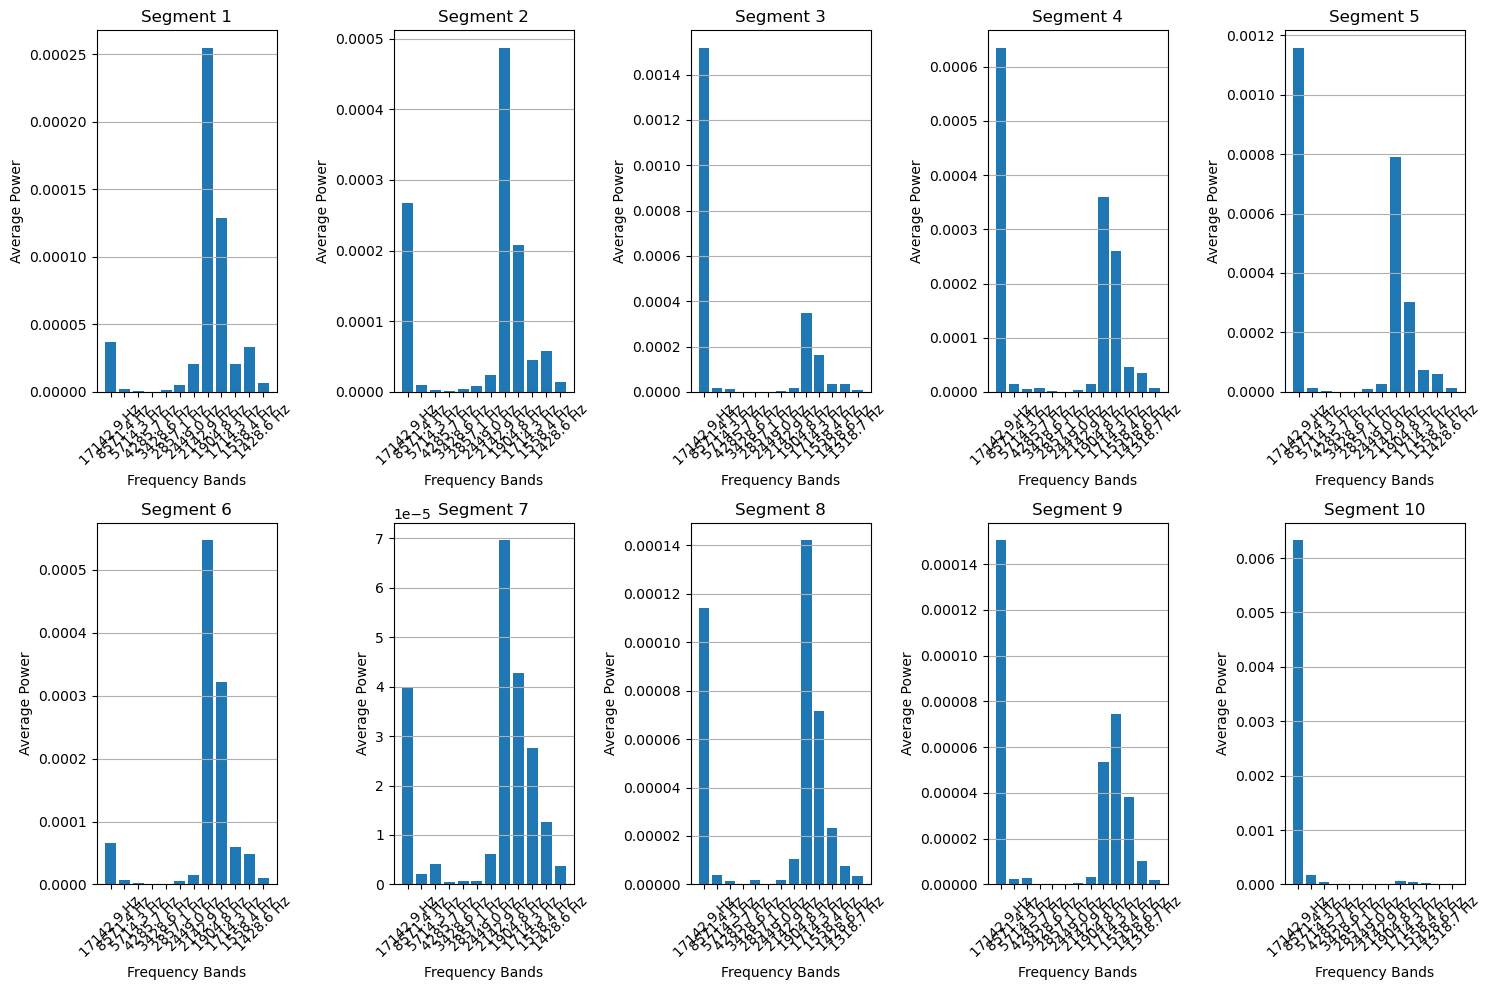

In [29]:
plot_dwt_powers(processed_segments_wavelet, num_signals=10)
